In [29]:
import random
import networkx as nx
import torch

from deep_ebm.utils_ebm import show_graph, evaluate_model
from deep_ebm.utils_ebm import save_graph, compare_graphs, show_graph_grid, compare_statistics
from deep_ebm.gnn_ebm import GraphDataset, GNN_EBM, train_one_epoch_pcd, gibbs_ministeps

from src.torch_erg.utils import laplacian_matrix
from src.torch_erg.samplers import MHSampler_Hard
from src.torch_erg import load_pglib_opf as lp

from Plots_and_utils.graph_generators import *
from Plots_and_utils.plots import *
from Plots_and_utils.other_g_stats import *

In [60]:
import pickle as pkl

In [2]:
dataset_size = 200
graph_dimension = 30

---


## 30_IEEE dataset

In [5]:
name = '30_ieee'
ordmat, ordlist, buslist, countlist = lp.pow_parser(name)

ordmat = torch.tensor(ordmat)

In [38]:

class MySampler(MHSampler_Hard):
    def __init__(self, backend: str):
        super().__init__(backend)
    def observables(self, mtx):
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        avg_deg = torch.sum(mtx)/mtx.shape[0]

        return(torch.stack([edges, triangles, avg_deg], dim=0))

data_sampler = MySampler(backend='cpu')
betas = torch.tensor([0., 0., 0.], dtype=float) 
obs = data_sampler.observables(ordmat)

params, _ = data_sampler.param_run(graph=ordmat,
                      observables=obs,
                      params=betas,
                      niter=300000,
                      params_update_every=3,
                      save_every=50,
                      save_params=True,
                      alpha=0.001,
                      min_change=0.001)


100%|██████████| 300000/300000 [02:50<00:00, 1762.13it/s]

number of accepted steps is:  65898
number of rejected samples:  234102
number of effective updates is:  21966


In [40]:
params_for_estimates = torch.stack(params[-1000:]).mean(axis=0)
print("Estimated parameters: ", params_for_estimates)

Estimated parameters:  tensor([-2.3115,  0.0118, -2.3115], dtype=torch.float64)


In [41]:
obs_list, graphs_list = data_sampler.sample_run(graph=ordmat,
                      observables=obs,
                      params=params_for_estimates,
                      niter=50000,
                      save_every=50,
                      burn_in=0.2)


100%|██████████| 50000/50000 [00:27<00:00, 1811.69it/s]

number of accepted steps is:  7616
number of rejected samples:  42384
Mean obs:  tensor([41.1750,  2.7068,  2.7450], dtype=torch.float64)


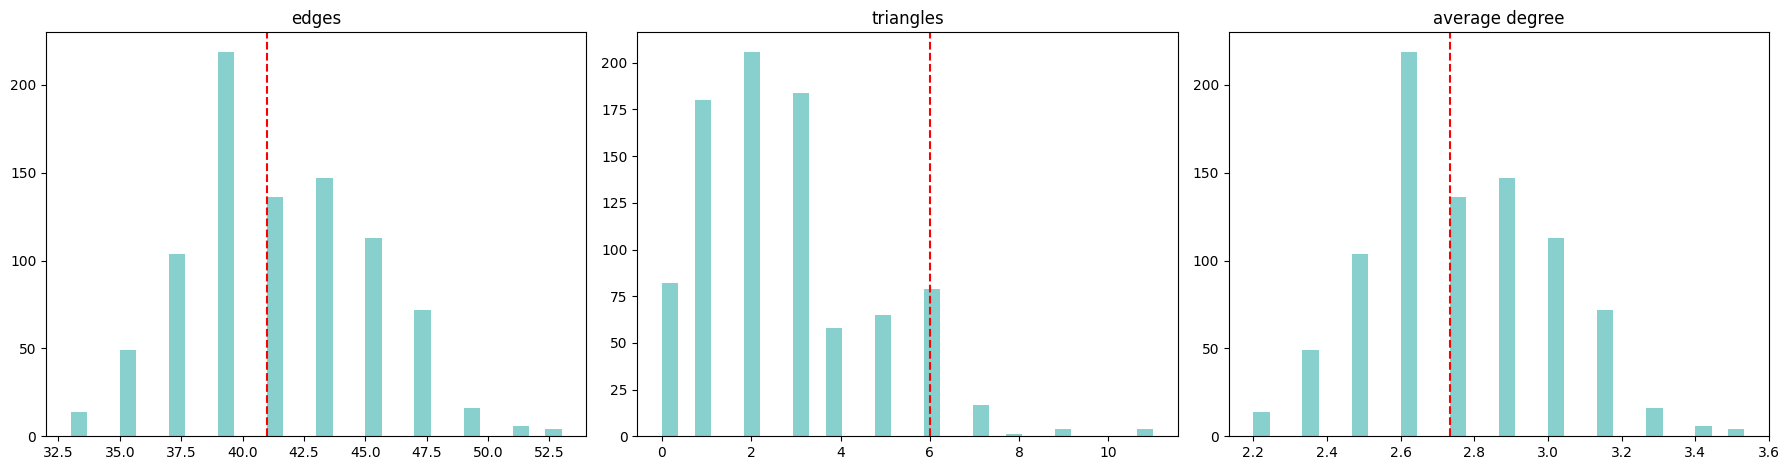

In [59]:
hist_obs_samples(obs_list, obs, obs_labels=['edges', 'triangles', 'average degree'])

In [43]:
len(graphs_list)

880

In [61]:
save_path = "/home/lorenzo/STORAGE/UNI/TESI/workspace/deep_erg_experiments/data/30IEEE_synth_dataset/30IEEE_synth_list_tensors.pkl"
with open(save_path, "wb") as f:
    pkl.dump(graphs_list, f)

In [63]:
nx_list = [nx.from_numpy_array(g.numpy()) for g in graphs_list]
save_path = "/home/lorenzo/STORAGE/UNI/TESI/workspace/deep_erg_experiments/data/30IEEE_synth_dataset/30IEEE_synth_list_netX.pkl"
with open(save_path, "wb") as f:
    pkl.dump(nx_list, f)

In [65]:
g_dataset = GraphDataset(nx_list)
save_path = "/home/lorenzo/STORAGE/UNI/TESI/workspace/deep_erg_experiments/data/30IEEE_synth_dataset/30IEEE_synth_list_GraphDataset.pkl"
with open(save_path, "wb") as f:
    pkl.dump(g_dataset, f)

---

## Tree dataset

In [44]:
class Measurer(MHSampler_Hard):
    def __init__(self, backend: str):
        super().__init__(backend)

    def observables(self,mtx):
        L = laplacian_matrix(mtx)
        a3 = torch.matmul(torch.matmul(mtx,mtx),mtx)

        edges = torch.sum(mtx)/2
        triangles = torch.trace(a3)/6
        ac = torch.linalg.eigvalsh(L)[1]
        deg = torch.diagonal(L)
        tri_diag = torch.diagonal(a3) / 2

        valid = deg > 1
        local_clust = torch.zeros_like(deg)
        local_clust[valid] = tri_diag[valid] / (deg[valid] * (deg[valid] - 1))
        avg_clustering = torch.mean(local_clust[valid])

        avg_degree = torch.sum(mtx, dim=1).mean()

        return(torch.stack([edges, triangles, ac, avg_degree, avg_clustering]))

measurer = Measurer(backend='cpu')


In [ ]:
synthetic_tree_dataset_torch = []
synthetic_tree_dataset_nx = []

for i in range(dataset_size):
    tmp = generate_tree(graph_dimension) #numpy_array
    synthetic_tree_dataset_torch.append(torch.Tensor(tmp))
    synthetic_tree_dataset_nx.append(nx.from_numpy_array(tmp))



In [46]:
tree_obs = [measurer.observables(g) for g in synthetic_tree_dataset_torch]

In [52]:
def hist_obs_samples(observables_samples: list, observable_data: torch.Tensor, w = 10, h = 8, scale = 0.6, color = "#11a39c", bins = 30, obs_labels = None):
    num_obs = observables_samples[0].shape[0]
    figsize = (num_obs * w * scale, h * scale)
    
    samples_np = torch.stack(observables_samples).cpu().numpy()
    data_np = observable_data.cpu().numpy()
    
    fig, axes = plt.subplots(1, num_obs, figsize=figsize, squeeze=False)
    
    for p in range(num_obs):
        ax = axes[0, p]

        obs_samples = samples_np[:, p]
        ax.hist(obs_samples, bins=bins, alpha=0.5, label='Sampled', color=color)
        ax.axvline(data_np[p], color='r', linestyle='--', label='Mean')

        if obs_labels is not None:
            ax.set_title(f'{obs_labels[p]}')
        else:
            ax.set_title(f'Observable {p}')
    
    plt.tight_layout()
    plt.show()

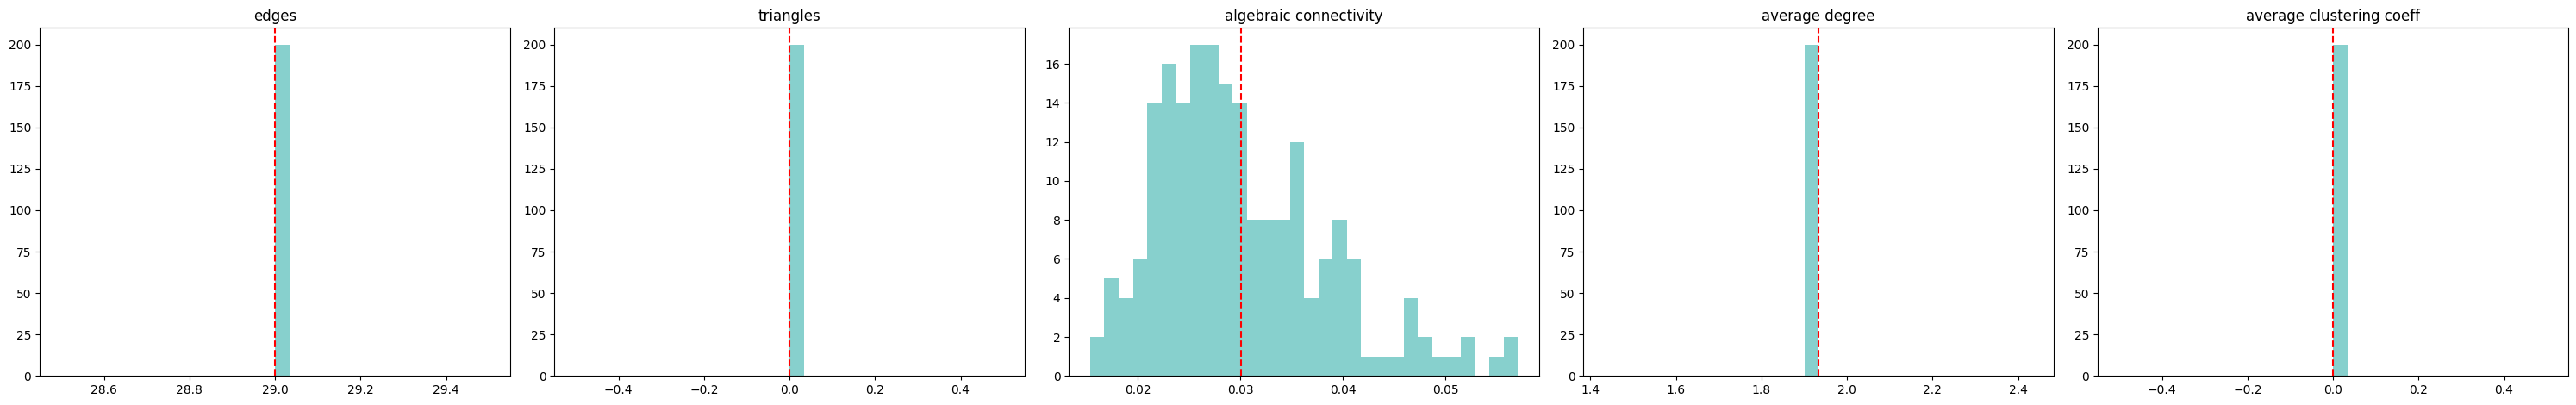

In [53]:
hist_obs_samples(tree_obs, torch.stack(tree_obs).mean(dim=0), obs_labels=['edges', 'triangles', 'algebraic connectivity', 'average degree', 'average clustering coeff'])

In [66]:
save_path = "/home/lorenzo/STORAGE/UNI/TESI/workspace/deep_erg_experiments/data/Tree30_dataset/Tree30_list_tensors.pkl"
with open(save_path, "wb") as f:
    pkl.dump(synthetic_tree_dataset_torch, f)

In [67]:
save_path = "/home/lorenzo/STORAGE/UNI/TESI/workspace/deep_erg_experiments/data/Tree30_dataset/Tree30_list_netX.pkl"
with open(save_path, "wb") as f:
    pkl.dump(synthetic_tree_dataset_nx, f)

In [68]:
t_dataset = GraphDataset(synthetic_tree_dataset_nx)
save_path = "/home/lorenzo/STORAGE/UNI/TESI/workspace/deep_erg_experiments/data/Tree30_dataset/Tree30_GraphDataset.pkl"
with open(save_path, "wb") as f:
    pkl.dump(t_dataset, f)

---

## 2 community dataset

In [54]:
synthetic_2comms_dataset_torch = []
synthetic_2comms_dataset_nx = []

for i in range(dataset_size):
    tmp = input_graph = gen_two_community_graph(max_nodes_per_community=graph_dimension, min_nodes_per_community=graph_dimension, p_intra=0.5 , links = 1) 
    synthetic_2comms_dataset_torch.append(torch.tensor(nx.to_numpy_array(tmp)))
    synthetic_2comms_dataset_nx.append(tmp)


In [55]:
community_obs = [measurer.observables(g) for g in synthetic_2comms_dataset_torch]

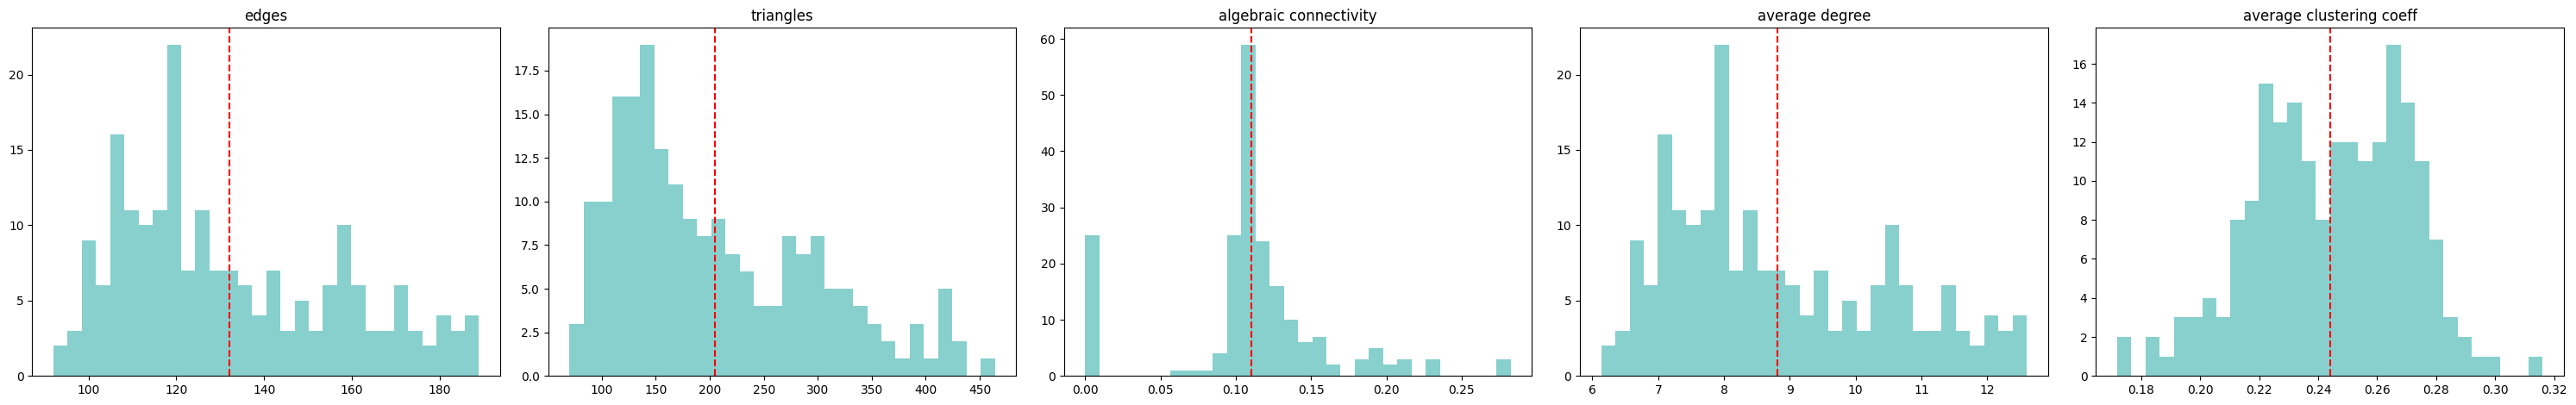

In [57]:
hist_obs_samples(community_obs, torch.stack(community_obs).mean(dim=0), obs_labels=['edges', 'triangles', 'algebraic connectivity', 'average degree', 'average clustering coeff'])

In [69]:
save_path = "/home/lorenzo/STORAGE/UNI/TESI/workspace/deep_erg_experiments/data/2community_dataset/2comms_list_tensors.pkl"
with open(save_path, "wb") as f:
    pkl.dump(synthetic_2comms_dataset_torch, f)

In [70]:
save_path = "/home/lorenzo/STORAGE/UNI/TESI/workspace/deep_erg_experiments/data/2community_dataset/2comms_list_netX.pkl"
with open(save_path, "wb") as f:
    pkl.dump(synthetic_2comms_dataset_nx, f)

In [71]:
c_dataset = GraphDataset(synthetic_2comms_dataset_nx)
save_path = "/home/lorenzo/STORAGE/UNI/TESI/workspace/deep_erg_experiments/data/2community_dataset/2comms_GraphDataset.pkl"
with open(save_path, "wb") as f:
    pkl.dump(c_dataset, f)